# Load 'Subway Hourly Ridership from https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data

In [1]:
import os 
import glob 
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import csv

from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc

ROOT = '../../../../data/rrochas'
FOLDER_PATH = f'{ROOT}/raw_data/Manhattan'
SAVE_PATH = f'{ROOT}/prediction_validation/Manhattan'

if False: 
    for year in [2020, 2021, 2022,2023]:
        MTA_hourly_year = []
        for month in range(1,13):
        
            MTA_hourly = pd.read_csv(f'{FOLDER_PATH}/Subway_Hourly/MTA_Turnstile_Manhattan_{year}_{month}.csv', 
                                    index_col=0,
                                    )
            MTA_hourly.index = pd.to_datetime(MTA_hourly.index)
            MTA_hourly = MTA_hourly.sort_index()
            # Convert into str:
            MTA_hourly['station_complex_id'] = MTA_hourly['station_complex_id'].astype(str)
            # Filter TRAM1 and TRAM2 stations: 
            MTA_hourly = MTA_hourly[~MTA_hourly['station_complex_id'].str.startswith(('TRAM1', 'TRAM2'))].copy()
            # Stats: 

            MTA_hourly = MTA_hourly.reset_index().pivot_table(index = 'transit_timestamp', columns = 'station_complex_id', values = 'ridership').sort_index()
            MTA_hourly.index.name = 'date'
            MTA_hourly.columns.name = 'Spatial Unit ID'

            MTA_hourly_year.append(MTA_hourly)
        
        MTA_hourly_year = pd.concat(MTA_hourly_year)
        print('Number of unique days', len(set(MTA_hourly_year.index.date)))
        print('Number of station_complex_id in df', MTA_hourly_year.columns.nunique())
        MTA_hourly_year.to_csv(f'{SAVE_PATH}/MTA_Turnstile_Manhattan_hourly_{year}.csv')
else:
    year_min = 2022
    year_max = 2023
    MTA_hourly = []
    for year in range(year_min, year_max+1):
        MTA_hourly_year = pd.read_csv(f'{SAVE_PATH}/MTA_Turnstile_Manhattan_hourly_{year}.csv', index_col=0)
        MTA_hourly_year.index = pd.to_datetime(MTA_hourly_year.index)
        MTA_hourly_year = MTA_hourly_year.fillna(0)
        MTA_hourly.append(MTA_hourly_year)
    MTA_hourly = pd.concat(MTA_hourly)
display(MTA_hourly.head())

,10,103,107,118,119,13,14,143,144,145,...,618,619,622,623,624,625,628,635,8,9
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,18.333333,8.200000,9.8,13.428571,26.714286,21.200000,16.333333,2.600000,2.00,2.000000,...,64.857143,36.142857,182.142857,22.000000,56.142857,40.000000,88.142857,37.833333,62.571429,121.571429
2022-01-01 01:00:00,15.000000,14.833333,5.8,14.333333,39.500000,22.166667,21.000000,3.166667,4.00,1.000000,...,91.000000,50.571429,35.857143,44.571429,49.666667,63.571429,63.428571,11.285714,29.333333,96.000000
2022-01-01 02:00:00,26.000000,7.000000,3.4,12.833333,30.571429,12.833333,21.400000,2.000000,2.25,2.000000,...,71.285714,43.500000,10.666667,23.857143,28.400000,49.714286,29.857143,7.200000,6.600000,40.714286
2022-01-01 03:00:00,19.666667,8.250000,2.6,7.285714,18.600000,9.166667,6.166667,1.666667,2.00,1.666667,...,33.714286,24.666667,4.600000,16.000000,10.333333,32.000000,18.000000,6.285714,2.666667,17.333333
2022-01-01 04:00:00,10.333333,3.166667,2.0,8.750000,13.000000,5.200000,6.200000,2.600000,2.50,1.000000,...,20.428571,14.285714,4.200000,12.166667,5.400000,20.142857,6.833333,5.000000,1.250000,11.500000


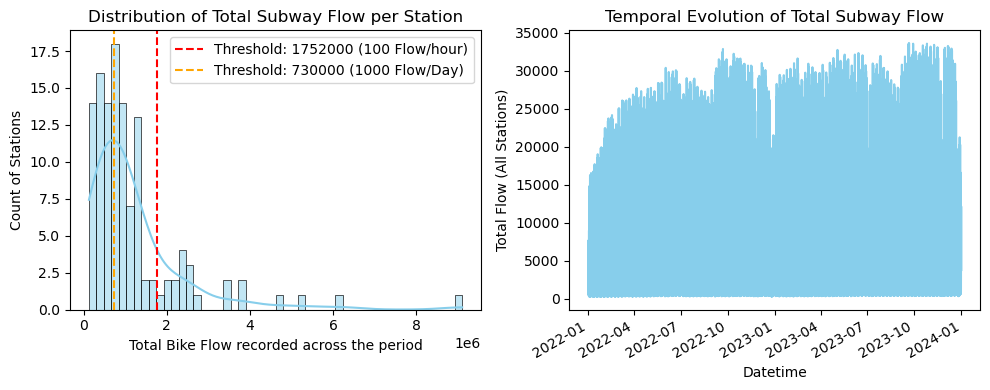

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Plot 1: Distribution (Somme par station / Colonnes) ---
sns.histplot(MTA_hourly.sum(), bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Total Subway Flow per Station')
axes[0].set_xlabel('Total Bike Flow recorded across the period')
axes[0].set_ylabel('Count of Stations')
# Set a vertical line related to the number of stations with more than 1 Flow per hour (i.e > 365*2*24 for a period of 2 years)
threshold = 365 * (year_max+1-year_min) * 24*100
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold} (100 Flow/hour)')
threshold = 365 * (year_max+1-year_min) * 1000
axes[0].axvline(threshold, color='orange', linestyle='--', label=f'Threshold: {threshold} (1000 Flow/Day)')
# display legend for the vertical line
axes[0].legend()
# --- Plot 2: Évolution Temporelle (Somme par timestamp / Lignes) ---
# On utilise sum(axis=1) pour sommer toutes les stations à chaque heure
MTA_hourly.sum(axis = 1).plot(ax=axes[1], color='skyblue')
axes[1].set_title('Temporal Evolution of Total Subway Flow')
axes[1].set_xlabel('Datetime')
axes[1].set_ylabel('Total Flow (All Stations)')

# Ajuste automatiquement l'espacement entre les subplots
plt.tight_layout()
plt.show()

# EDA :

Number of remaining time-slots after filtering 12216
Number of remaining time-slots after filtering 5302


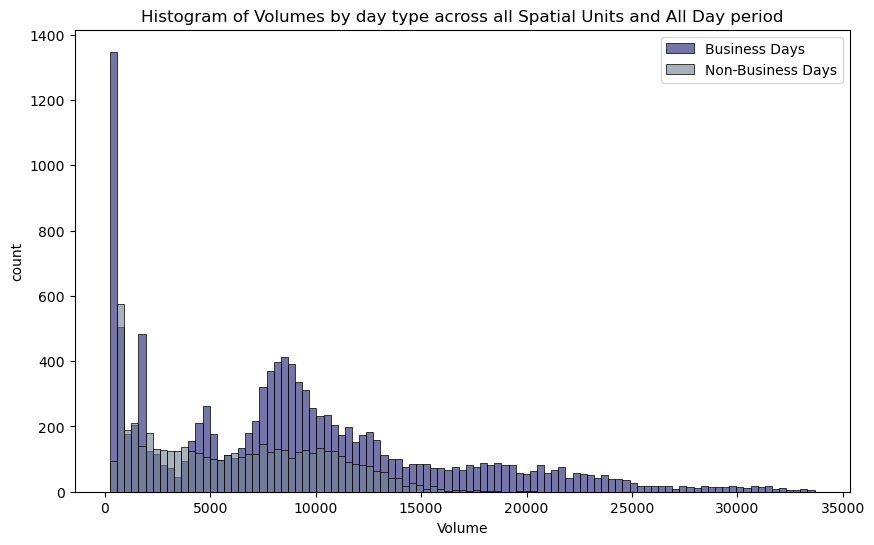

Number of remaining time-slots after filtering 2036
Number of remaining time-slots after filtering 884


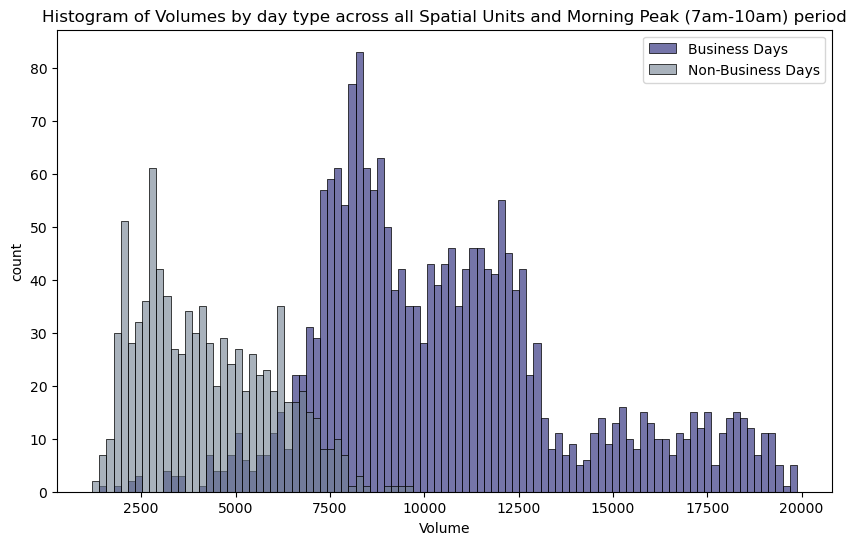

Number of remaining time-slots after filtering 1527
Number of remaining time-slots after filtering 663


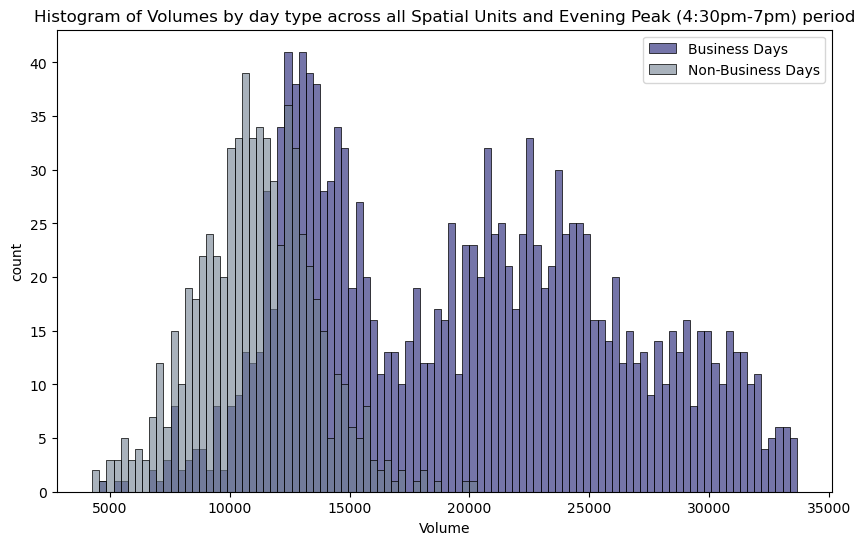

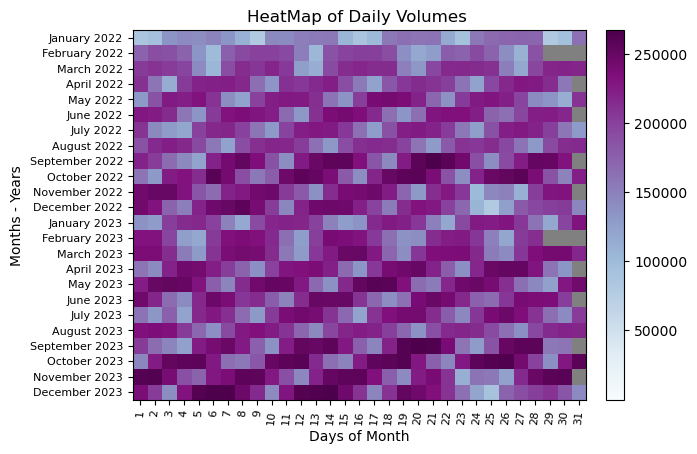

In [5]:
stats = 'count'
signal = 'in'
mode = 'manhattan_subway'
city = 'Manhattan'
df_raw = MTA_hourly.copy()
palette = [IN_bdc, IN_nbdc]


# ==== Histogram ====
for period in ['all_day','morning_peak','evening_peak']:
    folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}"
    save_path = f'{folder}/{mode}_hist_{signal}_{period}.pdf'# None 
    ts_bd, ts_nbd = get_histogram_per_day_type(df_raw,city= city,period = period,stats = stats, palette = palette,n_bins = 100,save_path= save_path)

# ==== Boxplot ====
if False: 
    # Too much stations -> impossible to use: 
    df_raw.columns.name = 'Spatial Unit ID'
    for period in ['all_day','morning_peak','evening_peak']:
        folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}_boxplot"
        save_path = f'{folder}/{mode}_boxplot_{signal}_{period}.pdf'# None
        df_bd, df_nbd = get_boxplot_per_spatial_unit_per_day_type(df_raw,period = period,city= city, palette = palette,save_path = save_path,df_all = df_raw)

# ==== HeatMap ====
cmap = 'BuPu' # 'hot' #'YlOrRd' # 'RdYlBu'
bool_reversed= False 
folder = f"../../../home/rrochas/prediction-validation/load_inputs/systematic_analysis/plots/{mode}/{mode}_heatmap"

save_path = f'{folder}/{mode}_heatmap_{city}.pdf'# None
df_agg = heatmap(df_raw,city= city,cmap = cmap,bool_reversed = bool_reversed,
                 save_path = save_path )

# Spatial visualisation: 

In [123]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from IPython.display import display, HTML
import html # Import the standard 'html' library


gdf = gpd.read_file(f'{ROOT}/prediction_validation//Manhattan/subway_stations.shp',crs = 'EPSG:4326',index_col=0)
print('Number of subway stations in Manhattan: ',gdf['Station ID'].nunique())

gdf_from_flows = gpd.GeoDataFrame(MTA_hourly.groupby('station_complex_id').agg({'latitude': 'first',
                                                                                      'longitude': 'first',
                                                                                      'ridership': 'sum',
                                                                                      })
                                                                                      )
gdf_from_flows = gdf_from_flows.set_geometry(gpd.points_from_xy(gdf_from_flows.longitude, gdf_from_flows.latitude))
gdf_from_flows.crs = 'EPSG:4326'

gdf_from_flows['ridership_100k'] = gdf_from_flows['ridership'] / 1000000


m = gdf_from_flows.explore('ridership_100k',
        tiles = 'CartoDB positron', 
        marker_type = 'circle',
        style_kwds={'style_function': lambda x: {'radius': np.sqrt(x['properties']['ridership'])/30},
                        'cmap': 'viridis',
                        'fill': True,
                    },
        legend_kwds={'caption': 'Ridership in Millions'}
        )


map_html_string = m._repr_html_()
escaped_map_html = html.escape(map_html_string, quote=True)
iframe_html = f'<iframe srcdoc="{escaped_map_html}" width="{800}" height="{400}" style="border:none;"></iframe>'
display(HTML(iframe_html))
print('Number of plotted complex IDs:', len(gdf_from_flows))


KeyError: 'Spatial Unit ID'